ЛАБОРАТОРНАЯ РАБОТА 4. ЛОГИЧЕСКИЕ МЕТОДЫ КЛАССИФИКАЦИИ

Цели и задачи

Цель лабораторной работы: изучение принципов построения информационных систем с использованием логических методов классификации.
Основные задачи:
–	освоение технологии внедрения алгоритмов на онове решающих списков в приложения;
–	освоение технологии внедрения алгоритмов на онове решающих деревьев в приложения;
–	изучение параметров логической классификации;
–	освоение модификаций логических методов классификации.
Оборудование и материалы

Для выполнения лабораторной работы рекомендуется использовать персональный компьютер со следующими программными средствами разработки (выбрать один или несколько програмных продуктов для практической реализации задач лабораторной работы): MS Visual Studio 2013 и выше; среда разработки Java, интерпретатор Python (Jupyter Notebook).

Методика и порядок выполнения работы

Постановка задачи.
В рамках учебной задачи необходимо произвести построение классификатора на основе логического дерева. В качестве набора данных используется набор данных об ирисах Фишера.
1.	Подключим библиотеки, которые потребуются для загрузки и первичного анализа данных


In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import tree

import warnings

from sklearn.preprocessing import LabelEncoder

%matplotlib inline

import seaborn as sns
from matplotlib import pyplot as plt

data_source = 'social-media.csv'

d = pd.read_csv(data_source)

columns = d.iloc[:, :5]
display(columns.head())

,UserId,UsageDuraiton,Age,Country,TotalLikes
0,1,2,55,Turkey,5
1,2,6,45,Canada,10
2,3,3,50,Ireland,7
3,4,4,35,South Africa,5
4,5,1,58,Turkey,2


2.	Для построения дерева классификации воспользуемся специальным классом sklearn.tree.DecisionTreeClassifier. Оценими точность модели методом hold-out (рис. 41). Следует обратить внимание, что если в методе ближайших соседей производилась оптимизация по одному параметру
K 	– 	количеству 	ближайших 	соседей, 	то 	при 	создании 	модели
DecisionTreeClassifier необходимо указать два параметра: максимальную глубину дерева (max_depth) и количество признаков разделения дерева (max_features).


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Подмножества для hold-out
X = d.drop(columns=['TotalLikes'])
y = d['TotalLikes']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=12)

# Обучение модели
tree = DecisionTreeClassifier(max_depth=5, random_state=21, max_features=2)
tree.fit(X_train, y_train)

# Получение оценки hold-out
tree_pred = tree.predict(X_holdout)
accuracy = accuracy_score(y_holdout, tree_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.10526315789473684


3.	Произведем оценку точности модели по методу cross validation (рис. 42), а также сделаем выводы об оптимальном значении параметра max_depth.

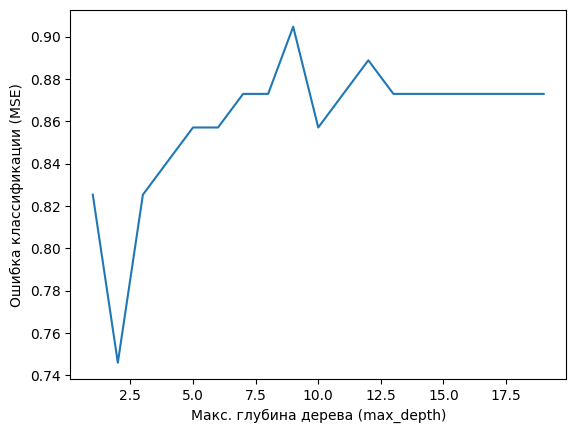

Оптимальные значения max_depth:  [2]


In [24]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Значения параметра max_depth
d_list = list(range(1, 20))

# Пустой список для хранения значений точности
cv_scores = []

# В цикле проходим все значения max_depth
for d in d_list:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        tree = DecisionTreeClassifier(max_depth=d, random_state=21, max_features=2)
        scores = cross_val_score(tree, X, y, cv=9, scoring='accuracy')
        cv_scores.append(scores.mean())

# Вычисляем ошибку (misclassification error)
MSE = [1 - x for x in cv_scores]

# Строим график
plt.plot(d_list, MSE)
plt.xlabel('Макс. глубина дерева (max_depth)')
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

# Ищем минимум
d_min = min(MSE)

# Пробуем найти прочие минимумы (если их несколько)
all_d_min = []
for i in range(len(MSE)):
    if MSE[i] <= d_min:
        all_d_min.append(d_list[i])

# Печатаем все max_depth, оптимальные для модели
print('Оптимальные значения max_depth: ', all_d_min)


4.	Оптимальное значение параметра max_depth модели получено, но в модели присутствует еще один параметр max_features, который был установлен в значение 2 (не изменялся и не оптимизировался). Для проведения cross validation по всем параметрам воспользуемся классом GridSearchCV пакета sklearn.model_selection

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import LabelEncoder

# Пример данных
# dx = pd.DataFrame({'Feature1': [1, 2, 3, 4], 'Feature2': ['A', 'B', 'C', 'D']})
# dy = pd.Series(['Class1', 'Class2', 'Class1', 'Class2'])

# Проверка и преобразование категориальных признаков
for column in dx.columns:
    if dx[column].dtype == 'object':
        le = LabelEncoder()
        dx[column] = le.fit_transform(dx[column])

# Проверка и преобразование категориальных меток классов
if dy.dtype == 'object':
    le = LabelEncoder()
    dy = le.fit_transform(dy)

# Значения параметра max_depth и max_features
tree_params = {'max_depth': range(1, 20), 'max_features': range(1, 4)}

# Инициализация модели
dtc = DecisionTreeClassifier(random_state=21)

# Инициализация GridSearchCV
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    tree_grid = GridSearchCV(dtc, tree_params, cv=9, verbose=True, n_jobs=-1)
    tree_grid.fit(dx, dy)

print('\n')
print('Лучшее сочетание параметров: ', tree_grid.best_params_)
print('Лучшие баллы cross validation: ', tree_grid.best_score_)

Fitting 9 folds for each of 57 candidates, totalling 513 fits


Лучшее сочетание параметров:  {'max_depth': 2, 'max_features': 2}
Лучшие баллы cross validation:  0.25396825396825395


Поясните вывод данного фрагмента. Поясните значение таких величин как fold, candidate, fit. Какие значения принимают данные величины в данном коде и почему?
Следует обратить внимание, что в результате оценки оптимальных параметров, фактически, было построено оптимальное дерево классификации. Доступ к данному дереву производится через поле best_estimator_ класса GridSearchCV. В коде (рис. 44) производится экспорт полученного дерева в формат .dot. Полученный формат можно преобразовать в .png через сервис сайта http://webgraphviz.com

5.	Оптимальные параметры определены, можно обучить модель и использовать ее для классификации

In [38]:
#Построим области решения для оптимального дерева
# max_features = 2, max_depth = 2
# Лучшие баллы cross validation:  0.25396825396825395

dtc = DecisionTreeClassifier(max_depth=2,
                              random_state=42,
                              max_features=2)
dtc.fit(dx, dy)
res = dtc.predict([[5.1, 3.5, 1.4, 0.2]])
print(res)

[10]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


6.	В заключении построим еще одну визуализацию процесса логической классификации – покажем решающие границы модели классификации

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X

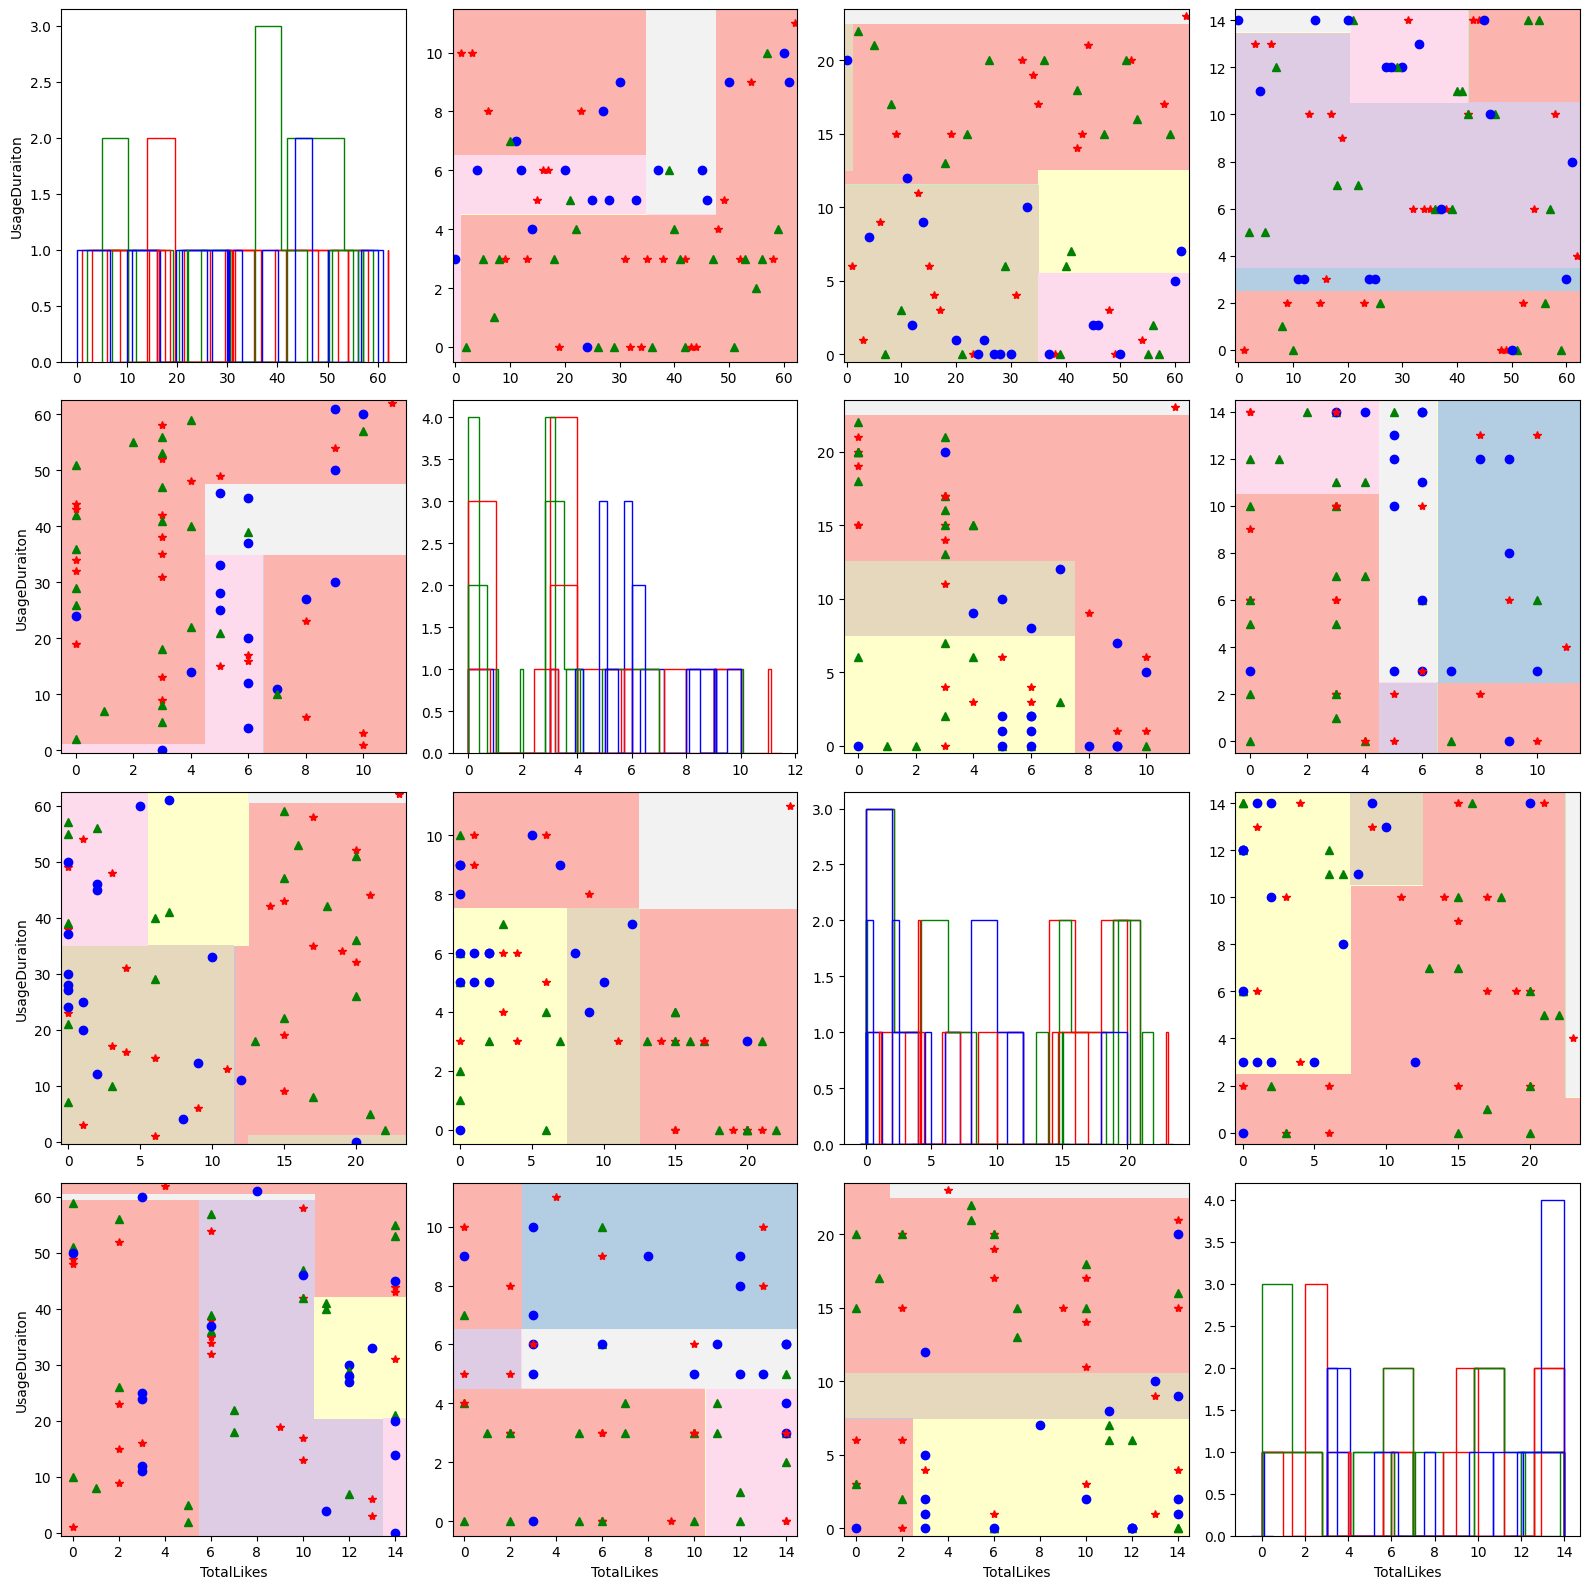

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import warnings

# Визуализация решающих границ модели классификации
plot_markers = ['r*', 'g^', 'bo']
answers = np.unique(dy)
num_features = dx.shape[1]

# Создаем подграфики для каждой пары признаков
f, places = plt.subplots(num_features, num_features, figsize=(16, 16))

fmin = dx.min() - 0.5
fmax = dx.max() + 0.5
plot_step = 0.02

# Обходим все subplot
for i in range(num_features):
    for j in range(num_features):

        # Строим решающие границы
        if i != j:
            xx, yy = np.meshgrid(np.arange(fmin.iloc[i], fmax.iloc[i], plot_step),
                                 np.arange(fmin.iloc[j], fmax.iloc[j], plot_step))
            model = DecisionTreeClassifier(max_depth=3, random_state=21, max_features=2)
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=UserWarning)
                model.fit(dx.iloc[:, [i, j]], dy)
            p = model.predict(np.c_[xx.ravel(), yy.ravel()])
            p = p.reshape(xx.shape)
            p[p == answers[0]] = 0
            p[p == answers[1]] = 1
            if len(answers) > 2:
                p[p == answers[2]] = 2
            places[i, j].contourf(xx, yy, p, cmap='Pastel1')

        # Обход всех классов
        for id_answer in range(len(answers)):
            idx = np.where(dy == answers[id_answer])
            if i == j:
                places[i, j].hist(dx.iloc[idx].iloc[:, i],
                                  color=plot_markers[id_answer % len(plot_markers)][0],
                                  histtype='step')
            else:
                places[i, j].plot(dx.iloc[idx].iloc[:, i], dx.iloc[idx].iloc[:, j],
                                  plot_markers[id_answer % len(plot_markers)],
                                  markersize=6)
        if j == 0:
            places[i, j].set_ylabel(dx.columns[j])
        if i == num_features - 1:
            places[i, j].set_xlabel(dx.columns[i])

# Убираем легенду
# f.legend(loc='upper right')

# Показываем график
plt.tight_layout()
plt.show()


7.	Выполните индивидуальное задание.

Важные замечания
1.	При выборе набора данных (data set) на ресурсах [3, 4] необходимо согласовать свой выбор с другими студентами группы и преподавателем с целью недопустимости выбора одинаковых вариантов.
2.	В рамках данного лабораторного курса рекомендуется использовать инструментарий Python (библиотеки, среду разработки) для решения поставленных задач.

Индивидуальное задание
1.	Студент самостоятельно выбирает набор данных на ресурсах [3, 4] для построения классификатора с использованием метода логической классификации и согласует свой выбор с преподавателем.
2.	Выполните построение модели классификации на основе дерева классификации. В ходе решения задачи необходимо решить следующие подзадачи:
2.1	Построение логического классификатора с заданием max_depth (максимальной глубины) и max_features (максимального количества признаков) пользователем (установить любые); визуализация дерева решений для выбранных исследователем параметров (в формате .png)
2.2	Вычисление оценки cross validation (MSE) для различнх значений max_depth (построить график зависимости);
2.3	Вычисление оценки cross validation (MSE) для различнх значений max_features (построить график зависимости);
2.4	Вычислите оптимальные значения max_depth и max_features. Обоснуйте свой выбор. Продемонстрируйте использование полученного классификатора.  
2.5	Выведите дерево в формате .png;
2.6	Выведите решающие границы полученной модели.

Содержание отчета и его форма

Отчет по лабораторной работе должен содержать:
1.	Номер и название лабораторной работы; задачи лабораторной работы.
2.	Реализация каждого пункта подраздела «Индивидуальное задание» с приведением исходного кода программы, диаграмм и графиков для визуализации данных.
3.	Ответы на контрольные вопросы.
4.	Экранные формы (консольный вывод) и листинг программного кода с комментариями, показывающие порядок выполнения лабораторной работы, и результаты, полученные в ходе её выполнения.
Отчет о выполнении лабораторной работы подписывается студентом и сдается преподавателю.

Контрольные вопросы

1.	Поясните принцип построения дерева решений.
2.	Укажите статистическое определение информативности.
3.	Поясните энтропийное определение информативности.
4.	Что такое многоклассовая информативность? Для чего она применяется?
5.	Поясните назначение и алгоритм бинаризации количественных признаков.
6.	Поясните порядок поиска закономерностей в форме конъюнкций.

Список литературы

Для выполнения лабораторной работы, при подготовке к защите, а также для ответа на контрольные вопросы рекомендуется использовать следующие источники: [1–5].
